----
title: SOM(Self Organizing Feature Maps)案例教程-用tensorflow实现
date: 2018-06-15 8:17:55
tags: [tensorflow教程, python, som]
toc: true
mathjax: true

------

<span></span>
<!-- more -->

### 简介

Kohonen自组织特征映射或SOMs，是由芬兰科学院教授Teuvo Kohonen发明的，他们提供了一种在低维空间（通常是一维或二维）表示多维数据的方法。这个降低矢量维度的过程本质上是一种称为矢量量化的数据压缩技术。此外，Kohonen技术创建了一个网络，以这种方式存储信息，以保持训练集内的任何拓扑关系。

SOM一个常见示例是将颜色从其三维空间（红色，绿色和蓝色）映射到两个维度。图1显示了一个SOM训练的例子，用于识别右侧显示的八种不同颜色。颜色作为向量呈现给网络 - 每个颜色分量都有一个维度 - 网络已经学会在二维空间中表示它们。注意，除了将颜色聚类到不同的区域之外，通常还会发现类似属性的区域彼此相邻。 

<div align="center">
    <img src="images/som-1.png" />
图1 经过训练的SOM
</div>

### 网络结构

SOM(Self Organizing Feature Maps)的网络结构非常简单, 很适合作为一个入门案例. 如图2所示, 本教程讨论的是一个二维SOM. 这个网络可以被当作一个两层网络: 输入层和输出层. 输入层只有一个节点, 我们用X表示输入, 输出层是一个7x7的矩阵或者说表格. 因为我们要对颜色进行分类, 所以我们设输入向量x是一个三维向量, 如[0 0 1], 代表一种颜色. 输出层的每个神经元有一个权重向量W, 我们这个网络中就有49个权重向量, 而且向量的维数与输入向量相等, 也是3, 这样这些权重向量也可以被当作一种颜色的数值表示, 所以可以被可视化成图1的样子.

<div align="center">
<img src="images/som-2.png" />
图2 SOM神经网络架构
</div>

### 学习过程

SOM是无监督学习, 不需要成对的数据. SOM的学习过程可以总结成一句话, 就是调整输出层权重W以便于让相邻的节点具有相似的权重. 具体来说分为一下的步骤:

- 1. 每个节点的权重都被随机初始化。

- 2. 从训练数据集中随机选择向量x并将其输入到网格。

- 3. 检查每个输出层节点以计算哪一个的权重最像输入向量。获胜节点通常被称为最佳匹配单元（BMU）或激活单元。

- 4. 现在计算BMU邻域节点, 以BMU为圆心, 处于半径R内的节点都被称为邻域。R是一个开始较大的值，通常设置为输出层的“半径”，但会随着训练逐步减小。在该半径内发现的任何节点都被视为在BMU的邻域内。

- 5. 调整每个邻域节点（步骤4中找到的节点）权重以使它们更像输入向量。节点越靠近BMU，其权重调整的就越大。

- 6. N次迭代重复步骤2。

### 代码实现

下面我们用tensorflow逐步实现这些过程.

#### 初始化权重

In [ ]:
import tensorflow as tf
import numpy as np
sess = tf.InteractiveSession()


In [ ]:
def _locations(shape):
    for r in range(shape[0]):
        for c in range(shape[1]):
            yield [r*1.0, c*1.0]

def init(shape = (13,13), dim=3, num_iters=200, learning_rate=0.5):
    '''shape: 输出层节点数
    dim: 权重向量的维数
    '''
    weights = tf.Variable(tf.random_normal([shape[0]*shape[1], dim],mean=0.5, stddev=0.1, dtype="float64"), name="weights", dtype=tf.float64)
    x = tf.placeholder("float64", [1,dim], name='X')
    locations = np.array(list(_locations(shape)))
    locations = tf.constant(locations)
    num_iters = tf.constant([num_iters], dtype=tf.float64)
    learning_rate = tf.constant([learning_rate], dtype=tf.float64)
    radius = tf.constant([shape[0]/2], dtype=tf.float64)
    return {
        'weights':weights,
        'x':x,
        'locations':locations,
        'learning_rate':learning_rate,
        'num_iters':num_iters,
        'radius': radius
    }
    

In [ ]:
vs = init()
w, x = vs['weights'], vs['x']
sess.run(tf.global_variables_initializer())
# sess.run(w)
print(w.eval()[:5])
print(vs['locations'].eval())

### 寻找最佳匹配单元BMU

用欧几里得距离来衡量两个向量之间的相似性. 公式是:

<img src="images/som-dist.png" />


In [ ]:
def calculate_bmu(weights, x):
    '''找到最佳匹配单元'''
    sub = tf.subtract(weights, x)
    sq = tf.square(sub)
    rs = tf.reduce_sum(sq, -1)
    index = tf.argmin(rs, axis=0)
    return index


通过下面代码大概测试一下程序是否能跑通

In [ ]:
vs = init()
w, x = vs['weights'], vs['x']
index = calculate_bmu(w, x)
sess.run(tf.global_variables_initializer())
x0 = np.zeros([1,3], dtype=np.float64)
print(x0)
# sess.run(index, feed_dict={x: x0})
i= index.eval(feed_dict={x: x0})
W = w.eval()
print(i)
print(W[i])
print(W[:5])

### 计算邻域节点

首先我们要确定邻域的半径, 然后才能找到半径以内的节点.

计算邻域半径的公式是:

<img src="images/som-radius.png" />

其中, t表示时间步骤, 可以把它当作训练的迭代次数, $\sigma$ 表示半径, $\sigma_0$表示输出层矩阵的宽度, $\lambda$表示最大迭代次数.  这个函数反映了, 随着训练的迭代增多, 半径会逐渐缩小.

得到半径后, 我们可以计算邻域内的点了:


<img src="images/som-neighbor.png" />

In [ ]:
def calculate_radius_lrate(iter_step, num_iters, radius0, learning_rate0):
    '''计算半径和学习率
    iter_step: 迭代次数
        num_iters: 总迭代次数
        segma: 初始的'''
    div = tf.negative(tf.divide(iter_step, num_iters))
    radius =  tf.multiply(radius0, tf.exp(div))
    learning_rate = tf.multiply(learning_rate0, tf.exp(div))
    return radius, learning_rate

def neighbors(radius, bmu_index, locations):
    '''radius: 半径
    bmu_index: 激活神经元的索引
    locdations: 表示神经元在输出层的位置的向量
    return: 表示邻域的蒙版向量'''
    slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
#     print('slice:', slice_input.eval())
    slice_input = tf.cast(slice_input, tf.int64)
    bmu = tf.slice(locations, slice_input, [1, 2])
#     print('bmu:', bmu.eval())

    sub = tf.subtract(locations, bmu)
    # 向量距离的平方和
    dist_square = tf.reduce_sum(tf.pow(sub, 2),1)
    # 用一个蒙板表示被选邻域内的节点
    mask = tf.pow(radius, 2) >= dist_square
    return {
        'mask':mask,
        'dist_square':dist_square
    }

简单测试上面的函数, 确保能正常运行:

In [ ]:
vs = init()
iter_step = tf.constant([100], dtype=tf.float64)
radius, learning_rate = calculate_radius_lrate(iter_step, vs['num_iters'], vs['radius'], vs['learning_rate'])
# sess.run(tf.global_variables_initializer())
# sess.run([radius, learning_rate])
print(radius.eval())
print(learning_rate.eval())

In [ ]:
bmu_index = tf.constant([85], dtype=tf.float64)
mask = neighbors(radius, bmu_index, vs['locations'])['mask']
l = int(int(mask.shape[0])**0.5)
rmask = tf.reshape(mask, (l, l))
# sess.run(rmask)
# print(vs['locations'].eval())
# print(mask.eval())
print('从下面的矩阵种可以大概看出激活的神经元(True)')
print(rmask.eval())

### 更新权重

我们先来看一下, 权重的更新公式:

$$
W(t+1) = W(t) + Θ(t)L(t)(X(t) - W(t))
$$

公式中符号的意义:

- $X(t)$t时刻的输入
- $W(t)$t时刻的权重
- $W(t+1)$t+1时刻的权重
- $L(t)$t时刻的学习率, 所有邻域内的神经元具有相同的$L(t)$
- $Θ(t)$t时刻某个神经元距离bmu的距离的函数, 是学习率的权重, 它使得距离bmu近的神经元更新的权重更大, 受输入的影响更多

计算$L(t)$的公式如下:

$$
L(t) = L_0 \exp(- {t \over \lambda}) ; t = 1, 2, 3 ...
$$

其中: 

- t代表时间步, 也叫当前迭代次数
- $\lambda$代表总迭代次数
- $L_0$代表初始的学习率, 通常是输出层矩阵的长度或宽度


计算$Θ(t)$的公式如下:

$$
\Theta(t) = \exp ( -{dist^2 \over {2\sigma^2(t)}} )
$$

符号的意义如下:

- $\sigma$ 表示t时刻的邻域半径
- $dist$ 表示神经元到bmu的距离

#### 先来计算$\Theta(t)$

In [ ]:
def theta(radius, dist_square):
    '''
    radius: 半径
    dist_square: 神经元到BMU的欧几里得距离的平方
    '''
    c = tf.constant(2, dtype=tf.float64)
    div = tf.divide(dist_square, tf.multiply(c, tf.pow(radius, 2)))
    minus = tf.constant(-1, dtype=tf.float64)
    return tf.exp(tf.multiply(minus, div))

#### 计算$L(t)$

$L(t)$的计算图在函数`calculate_radius_lrate`中已经给出.

#### 更新权重

In [ ]:
def update_weights(weights, mask, xt, lr, theta):
    '''
    weights: 所有神经元的权重矩阵
    mask: 邻域神经元的蒙版
    xt: 输入
    lr: 学习率
    theta: 学习率的权重
    '''
    theta = tf.expand_dims(theta, 1)
    cha = tf.subtract(xt, weights)
    cha = tf.multiply(cha, lr)
    cha = tf.multiply(cha, theta)
    # 把非邻域内的神经元的更新值设置成0 , 这样这些权重就不会更新
    mask = tf.cast(mask, tf.float64)
    mask = tf.expand_dims(mask, 1)
    cha = tf.multiply(cha, mask)
    return tf.add(weights, cha)

#### 测试以上函数

In [ ]:
radius, learning_rate = calculate_radius_lrate(iter_step, vs['num_iters'], vs['radius'], vs['learning_rate'])
bmu_index = tf.constant([35], dtype=tf.float64)
nbs = neighbors(radius, bmu_index, vs['locations'])
theta_ = theta(radius, nbs['dist_square'])
# sess.run(theta_)
print(theta_.eval())

In [ ]:
x = vs['x']
uw = update_weights(vs['weights'], nbs['mask'], x, learning_rate, theta_)
# sess.run(uw, feed_dict={x:x0})
sess.run(tf.global_variables_initializer())
print(vs['weights'].eval()[:5])
print(uw.eval(feed_dict={x:x0})[:5])


### 训练

现在即将要大功告成, 我们需要整合上面所有的函数, 然后进行训练.

#### 训练数据

训练数据就是15种颜色. 将这些数据迭代1000次.

In [ ]:
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

#### 输出层可视化函数

这个函数用于监控在训练过程种输出层权重的变化.

In [ ]:
from matplotlib import pyplot as plt
from IPython import display
def show_image(data, iter_step, radius, lrate):
    l = int(data.shape[0]**0.5)
    data = data.reshape([l, l,3])
    display.clear_output(wait=True)
    plt.clf()
    _ = plt.imshow(data, aspect="auto")
    plt.figtext(0.5, 0.8, f'radius: {radius}', fontsize=15)
    plt.figtext(0.5, 0.7, f'lrate: {lrate}', fontsize=15)
    plt.figtext(0.5, 0.6, f'iter_step: {iter_step}', fontsize=15)
    display.display(plt.gcf())


#### 训练函数

In [ ]:

def train(colors, num_iters, shape=(13,13),  dim=3, learning_rate=0.5, print_step=40):
    '''训练函数
    colors: 颜色向量
    num_iters: 总训练次数
    shape: 输出层shape
    dim: 输出层向量维度
    learning_rate: 初始学习率'''
    params = init(shape = shape, dim=dim, num_iters=num_iters, learning_rate=learning_rate)
    bmu = calculate_bmu(params['weights'], params['x'])
    iter_step = tf.placeholder(tf.float64, [1], name="iter-step")
    radius, lrate = calculate_radius_lrate(iter_step, params['num_iters'], params['radius'], params['learning_rate'])
    nbs = neighbors(radius, bmu, params['locations'])
    theta_ = theta(radius, nbs['dist_square'])
    new_weights = update_weights(params['weights'], nbs['mask'], params['x'], lrate, theta_)
    train_op = tf.assign(params['weights'], new_weights)
    # 初始化所有变量
    sess.run(tf.global_variables_initializer())
    for i in range(num_iters):
        
            
        if i == (num_iters-1):
            positions = []
        for j in range(colors.shape[0]):
            x = colors[j].reshape([1,3])
            x.astype('float64')
            radius_, lrate_,bmu_, new_weights_, _ = sess.run([ radius, lrate,bmu,new_weights,train_op], feed_dict={
                params['x']:x,
                iter_step:[i+1]
            })
            if i == (num_iters-1):
                positions.append(bmu_)
                
        if i % print_step == 0 :
            show_image(new_weights_, i, radius_, lrate_)
    print('Train Finished')
    return {
        'weights':  new_weights_,
        'positions':positions
    }
    

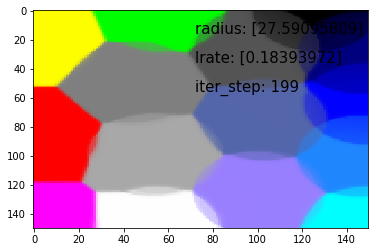

Train Finished


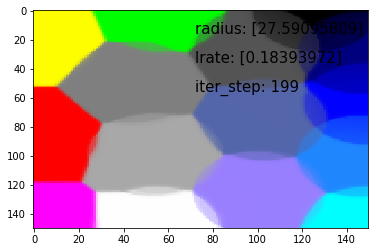

In [82]:
%matplotlib inline
from matplotlib import pyplot as plt
data = train(colors, 200, print_step=1, shape=(150,150))